**Лабораторная работа 4**

Цель работы - разобраться с основами работы с нейросетями с использованием библиотеки TensorFlow, получить новые навыки и умения.

Используется набор данных: Russia Real Estate 2018-2021 https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021

Выполнил Кирилл Запорожченко

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [3]:
path_to_csv = 'kc_house_data.csv'
df = pd.read_csv(path_to_csv)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#### Подготовка набора данных

In [4]:
def data_overview(df, head=5):
    print(" MISSING VALUES ".center(125,'-'))
    print(df.isnull().sum())
    print(" DUPLICATED VALUES ".center(125,'-'))
    print(df.duplicated().sum())
    print(" DATA TYPES ".center(125,'-'))
    print(df.dtypes)

data_overview(df)

------------------------------------------------------- MISSING VALUES ------------------------------------------------------
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
----------------------------------------------------- DUPLICATED VALUES -----------------------------------------------------
0
--------------------------------------------------------- DATA TYPES --------------------------------------------------------
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfro

Пропусков нет. Категориальные показатели изначально приведены к удобному для исопльзования виду.

Присутствуют дубликаты, необходимо от них избавиться:

In [5]:
df = df.drop_duplicates()
data_overview(df)

------------------------------------------------------- MISSING VALUES ------------------------------------------------------
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
----------------------------------------------------- DUPLICATED VALUES -----------------------------------------------------
0
--------------------------------------------------------- DATA TYPES --------------------------------------------------------
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfro

Дополнительно почистим набор данных от выбросов:

In [6]:
# #Фильтрация выбросов
# df = df[df['price'] > 0]
# df = df[df['price'] < 125000000]
# df = df[df['rooms'] > 0]
# df = df[df['kitchen_area'] <= 40]
# df = df[df['area'] <= 100]
# df = df[df['area'] >= 19]
# df = df[df['geo_lat'] > 0]
# df = df[df['geo_lon'] > 0]

# #Для работы берем только часть данных, т. к. 500+ мб. будут очень долго считаться
# ndf = df.sample(frac=0.1)
# df = ndf.copy()

#### Выбор показателей

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\kanze\AppData\Local\Temp\ipykernel_17828\3784545759.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016762,0.001286,0.005160,-0.012258,-0.132109,0.018525,-0.002721,0.011592,-0.023783,0.008130,-0.010842,-0.005151,0.021380,-0.016907,-0.008224,-0.001891,0.020799,-0.002901,-0.138798
price,-0.016762,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605567,0.323816,0.054012,0.126434,-0.053203,0.307003,0.021626,0.585379,0.082447
bedrooms,0.001286,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477600,0.303093,0.154178,0.018841,-0.152668,-0.008931,0.129473,0.391638,0.029244
bathrooms,0.005160,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685342,0.283770,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.087175
sqft_living,-0.012258,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876597,0.435043,0.318049,0.055363,-0.199430,0.052529,0.240223,0.756420,0.183286
sqft_lot,-0.132109,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183512,0.015286,0.053080,0.007644,-0.129574,-0.085683,0.229521,0.144608,0.718557
floors,0.018525,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.049614,0.125419,0.279885,-0.011269
waterfront,-0.002721,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072075,0.080588,-0.026161,0.092885,0.030285,-0.014274,-0.041910,0.086463,0.030703
view,0.011592,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167649,0.276947,-0.053440,0.103917,0.084827,0.006157,-0.078400,0.280439,0.072575
condition,-0.023783,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158214,0.174105,-0.361417,-0.060618,0.003026,-0.014941,-0.106500,-0.092824,-0.003406


In [8]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Выберем показатели для модели:

In [9]:
x = df[['id', 'bedrooms', 'sqft_living',
       'sqft_lot', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
        'sqft_living15', 'sqft_lot15']]
y = df['price']


In [10]:
# Разделение на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=17)

In [11]:
print(
    "Using %d samples for training and %d for validation"
    % (len(x_train), len(x_test))
)

Using 16209 samples for training and 5404 for validation


In [12]:
from tensorflow import keras
import keras.layers as layers

**Обучение модели**

Опытным путем была найдена оптимальная скорость обучения равная 0.0097

Используется модель регрессии

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

model.compile( # Скомпилируем модель
    optimizer=keras.optimizers.RMSprop(1e-4),
    loss=[keras.losses.MeanSquaredError(), "binary_crossentropy"],
    metrics=[tf.keras.metrics.binary_crossentropy, "accuracy"])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [16]:
history = model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10


507/507 [==============================] - 2s 2ms/step - loss: 664228704813056.0000 - binary_crossentropy: -525133.2500 - accuracy: 0.0000e+00
Epoch 2/10
507/507 [==============================] - 1s 2ms/step - loss: 443184689709056.0000 - binary_crossentropy: -524197.0938 - accuracy: 0.0000e+00
Epoch 3/10
507/507 [==============================] - 1s 2ms/step - loss: 298173776003072.0000 - binary_crossentropy: -392209.3750 - accuracy: 0.0000e+00
Epoch 4/10
507/507 [==============================] - 1s 2ms/step - loss: 178645205254144.0000 - binary_crossentropy: -848112.1875 - accuracy: 0.0000e+00
Epoch 5/10
507/507 [==============================] - 1s 2ms/step - loss: 104473837961216.0000 - binary_crossentropy: -1134169.7500 - accuracy: 0.0000e+00
Epoch 6/10
507/507 [==============================] - 1s 2ms/step - loss: 63041529970688.0000 - binary_crossentropy: -956398.4375 - accuracy: 0.0000e+00
Epoch 7/10
507/507 [==============================] - 1s 2ms/step - loss: 

<Axes: >

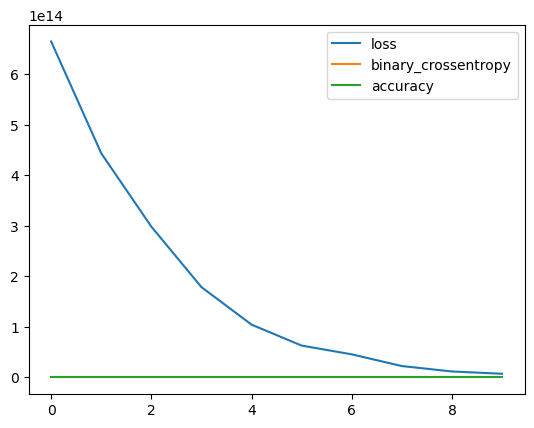

In [17]:
# Создаем датафрейм из истории обучения
hist = pd.DataFrame(history.history)

# Строим график
hist.plot()

Исходя из вывода и графика видно, что значение функции потерь уменьшается с каждой эпохой, что говорит о том, что модель обучается и улучшает свою производительность. Значение средней абсолютной ошибки также уменьшается, что указывает на то, что предсказания модели становятся ближе к фактическим значениям.

#### Оценка точности предсказания

In [ ]:
model.save("rurealest.h5")

c:\Users\kanze\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model1 = keras.models.load_model("rurealest.h5")

In [ ]:
y_pred = model.predict(x_test)

169/169 [==============================] - 0s 2ms/step


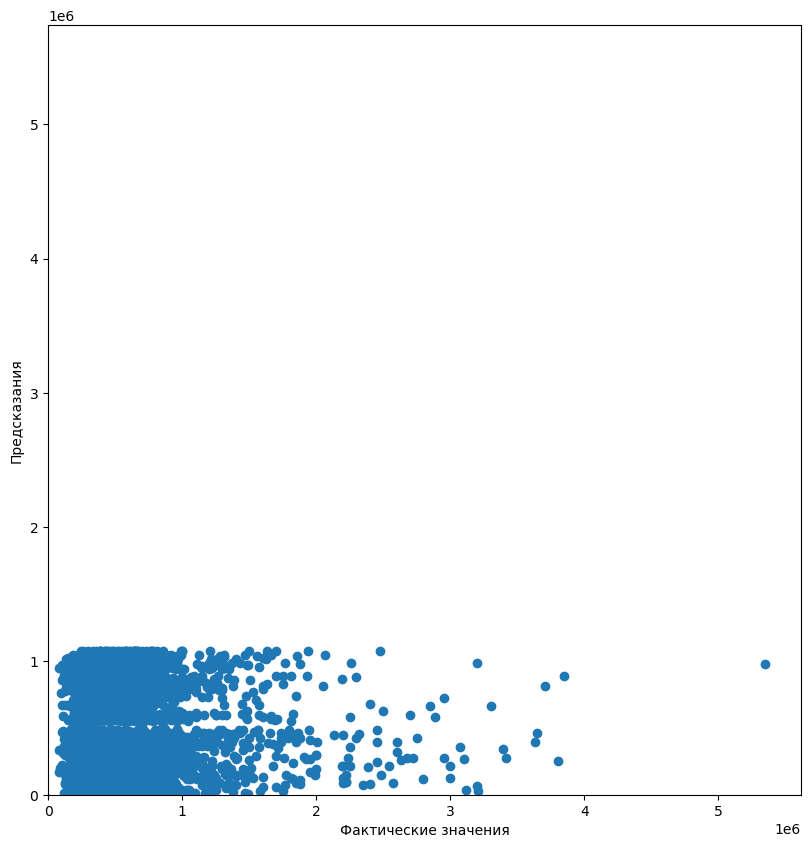

In [ ]:
#Строим график рассеяния (scatter plot)
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

plt.show()


**Интерпретация**

График показывает, что модель достаточно хорошо справляется с предсказанием более низких значений стоимости, но становится менее точной при предсказании более высоких значений. Это связано с тем, что в модели количество предложений жилья с заоблочно высокими ценами небольшое относительно предложений с адекватной стоимостью, поэтому модель хуже предсказывает такие значения.

#### Заключение

# Новый раздел

В ходе работы я получил навыки работы с нейросетями с использованием библиотеки TensorFlow. Сделав несколько ошибок и разобравшись с отличиями моделей классификации и регрессии и целями применения каждой из них, выбрал для работы модель регрессии. Построив графики, определил, на сколько хорошо обучилась модель и оценил, как хорошо она способна предскзать значение целевого параметра.